## Семинар 5: "Улучшение сходимости нейросетей"

ФИО: Валиахметов Булат Ильдарович

In [76]:
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
%matplotlib inline

На этом семинаре мы попробуем улучшить результаты, полученные на предыдущем занятии
Для этого нам понадобятся следующие вещи:
* Dropout
* Batch Normalization
* Инициализация весов

### Часть 1: Инициализация весов

На лекции доказывалось, что при инициализации He и Glorot дисперсия активаций градиентов в каждом слое будут примерно равны. Давайте проверим это. 

In [2]:
# Dataloader
to_numpy = lambda x: x.numpy()
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                    ])
train_dataset = MNIST('.', train=True, download=False, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=True)

In [3]:
images_train, labels_train = next(iter(train_loader))

In [4]:
## Usage example:
for X, y in train_loader:
    X = X.view(X.size(0), -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()
    pass

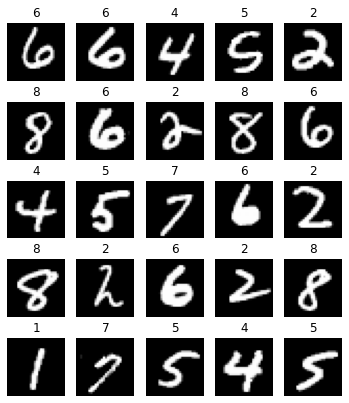

In [5]:
plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

<i> 1.1 </i> Инициализируйте полносвязную сеть нормальным шумом N(0, 0.1) с архитектурой 784 -> 500 x (10 раз) -> 10. В качестве активации возьмите tanh

In [34]:
def init_norm(layer, mean=0, std=1):
    # Тут надо быть аккуратным — можно случайно создать копию и менять значения у копии
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    #1 - веса сети
    #2 - нули ...
    #bias = torch.zeros_like(bias)
    weight.normal_(mean=0, std=std)
    
def init_uniform(layer, mean=0, std=1.0/12):
    weight = layer.state_dict()['weight']
    bias = layer.state_dict()['bias']
    bias.zero_()
    #1 - веса сети
    #2 - нули ...
    #bias = torch.zeros_like(bias)
    a = mean - std / np.sqrt(3)
    b = mean + std / np.sqrt(3)
    weight.uniform_(a, b)

def forward_hook(self, input_, output_, storage):
    std = input_[0].std().item()
    storage.append(std)

def backward_hook(self, grad_input, grad_output, storage):
    std = grad_input[0].std().item()
    storage.append(std)

    
# пример:
layer = nn.Linear(28*28, 10)
layer.register_forward_hook(forward_hook)
layer.register_backward_hook(backward_hook)
init_uniform(layer, 0.0, 0.1) # сюда надо подставить другие параметры

In [30]:
sizes = [28*28, 64, 32] + [16] * 30 + [10]

def normal(size_input, size_output):
    return 0.1
    # return 1

def xavier(size_input, size_output):
    d = 2 / (size_input + size_output)
    return np.sqrt(d)

def good_grad(size_input, size_output):
    d = 1 / size_output
    return np.sqrt(d)

def he_in(size_input, size_output):
    d = 2 / size_input
    return np.sqrt(d)

def he_out(size_input, size_output):
    d = 2 / size_output
    return np.sqrt(d)

<i>1.2 Пропустите батч изображений через нейронную сеть и вычислите дисперсию активаций. Затем вычислите градиент и получите дисперсию градиентов. Сравните эти значения между собой для разных слоев.</i>

In [65]:
def make_experiment(sizes, activation, init_layer_func, distr_std_func):
    layers = []
    back_std = []
    for_std = []
    for size_input, size_output in zip(sizes, sizes[1:]):

        layer = nn.Linear(size_input, size_output)
        layer.register_forward_hook(lambda self, inp, outp: forward_hook(self, inp, outp, for_std))
        layer.register_backward_hook(lambda self, inp, outp: backward_hook(self, inp, outp, back_std))
        init_layer_func(layer, mean=0.0, std=distr_std_func(size_input, size_output))
        layers.append(layer)
        layers.append(activation())
    print('New experiment with {} layers:'.format(len(layers)))
    del layers[-1]
    network = nn.Sequential(*layers)
    
    n_objects = 100
    X = images_train[:n_objects].view(n_objects, -1).data
    y = labels_train[:n_objects].data
    activations = network(X)
    loss_fn = torch.nn.NLLLoss()
    optimizer = torch.optim.Adam(network.parameters(), lr=0.001) 
    loss = loss_fn(activations, y)
    loss.backward()
    
    print('Forward STD:  mean = {0:.3e}, min = {1:.3e}, max = {2:.3e}'.format(np.mean(for_std), np.min(for_std), np.max(for_std)))
    print('Backward STD: mean = {0:.3e}, min = {1:.3e}, max = {2:.3e}'.format(np.mean(back_std), np.min(back_std), np.max(back_std)))
    plt.rcParams["figure.figsize"] = (12, 3)
    plt.subplot(121)
    plt.plot(for_std)
    plt.subplot(122)
    plt.plot(back_std)
    plt.show()

<i>1.3 Повторите эксперимент для инициализаций He и Xavier (формулы есть в лекции).</i>

ReLU, norm, He_in
New experiment with 66 layers:
Forward STD:  mean = 5.012e-01, min = 1.874e-01, max = 1.009e+00
Backward STD: mean = 5.112e-02, min = 1.261e-02, max = 1.040e-01


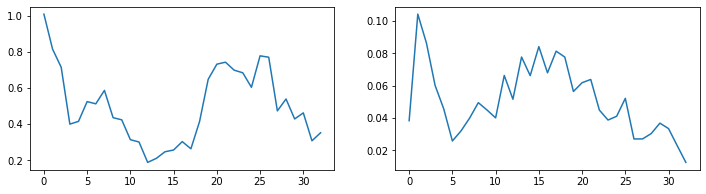

ReLU, norm, He_out
New experiment with 66 layers:
Forward STD:  mean = 2.876e+00, min = 3.628e-01, max = 6.677e+00
Backward STD: mean = 2.703e-02, min = 5.937e-03, max = 1.475e-01


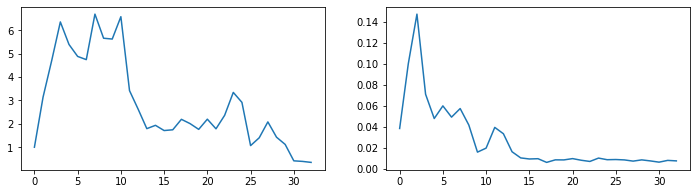

ReLU, uniform, He_in
New experiment with 66 layers:
Forward STD:  mean = 4.156e-02, min = 2.091e-17, max = 1.009e+00
Backward STD: mean = 2.144e-03, min = 9.371e-19, max = 3.830e-02


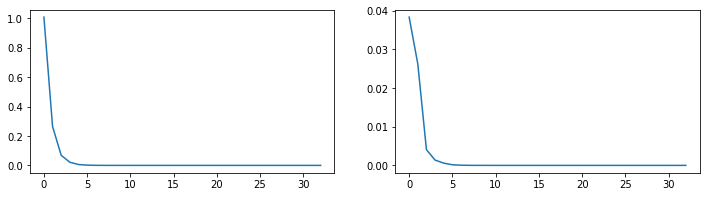

Tanh, uniform, He_in
New experiment with 66 layers:
Forward STD:  mean = 5.255e-02, min = 1.388e-11, max = 1.009e+00
Backward STD: mean = 2.619e-03, min = 1.902e-13, max = 3.830e-02


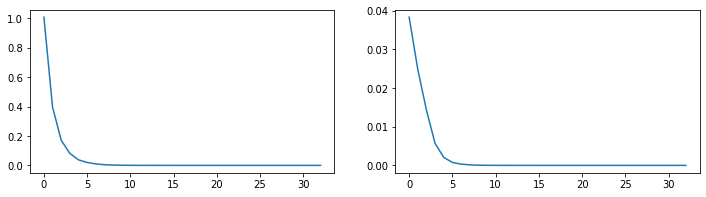

Tanh, uniform, Xavier
New experiment with 66 layers:
Forward STD:  mean = 4.848e-02, min = 2.953e-16, max = 1.009e+00
Backward STD: mean = 2.674e-03, min = 2.287e-18, max = 3.830e-02


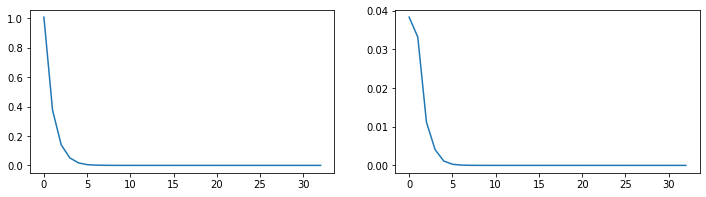

Tanh, norm, Xavier
New experiment with 66 layers:
Forward STD:  mean = 2.077e-01, min = 4.968e-02, max = 1.009e+00
Backward STD: mean = 4.696e-02, min = 2.629e-03, max = 1.159e-01


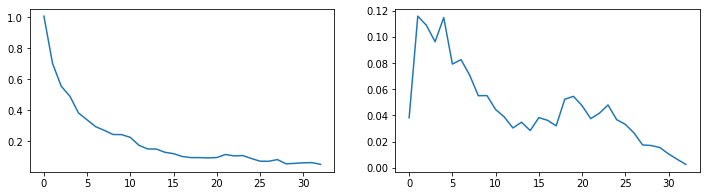

ReLU, uniform, Xavier
New experiment with 66 layers:
Forward STD:  mean = 4.177e-02, min = 1.777e-21, max = 1.009e+00
Backward STD: mean = 1.812e-03, min = 6.736e-23, max = 3.830e-02


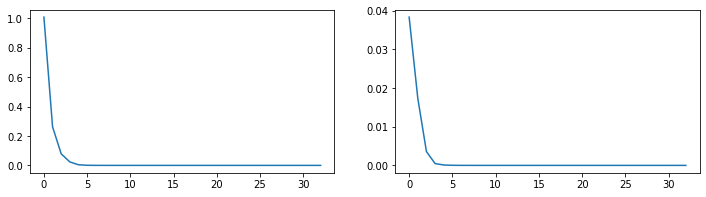

In [70]:
print('ReLU, norm, He_in')
make_experiment(sizes, nn.ReLU, init_norm, he_in)
print('ReLU, norm, He_out')
make_experiment(sizes, nn.ReLU, init_norm, he_out)
print('ReLU, uniform, He_in')
make_experiment(sizes, nn.ReLU, init_uniform, he_in)
print('Tanh, uniform, He_in')
make_experiment(sizes, nn.Tanh, init_uniform, he_in)

print('Tanh, uniform, Xavier')
make_experiment(sizes, nn.Tanh, init_uniform, xavier)
print('Tanh, norm, Xavier')
make_experiment(sizes, nn.Tanh, init_norm, xavier)
print('ReLU, uniform, Xavier')
make_experiment(sizes, nn.ReLU, init_uniform, xavier)

# make_experiment(sizes, nn.ReLU, init_uniform, he_in)
# make_experiment(sizes, nn.ReLU, init_uniform, he_in)

<i> 1.4 Сделайте выводы по первой части </i>

**Вывод**: скорость обучения нейронной сети существенно зависит от способа инициализации весов, причём каждый из способов сильно чувствителен к функции активации и выбору распределения (нормального или равномерного) при одинаковых средних и дисперсии.

### Часть 2: Dropout

Другим полезным слоем является Dropout. В нем с вероятностью 1-p зануляется выход каждого нейрона. Этот слой уже реализован в pyTorch, поэтому вновь реализовывать его не интересно. Давайте реализуем DropConnect — аналог Dropout. В нем с вероятностью 1-p зануляется каждый вес слоя.

<i> 2.1 Реализуйте линейный слой с DropConnect </i>

In [71]:
# полезная функция: .bernoulli_(p)
# не забывайте делать requires_grad=False у маски
# помните, что в вычислениях должны участвовать Variable, а не тензоры

class DropConnect(nn.Module):
    def __init__(self, input_dim, output_dim, p=0.5):
        super(DropConnect, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        self.p = p

    def forward(self, x):    
        mask = torch.zeros_like(self.linear.weight) + self.p
        if self.training:          
            mask.bernoulli_()

        mask = mask.data
        output = F.linear(x, self.linear.weight * mask, self.linear.bias)
        return output

<i> 
2.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Dropout между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU DropConnect вместо всех линейных слоев
</i>

In [72]:
class TestNetwork(nn.Module):
    def __init__(self, final_part):
        super().__init__()    
        
        channels = 1
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(channels, 2, 3, padding=1),    
            nn.MaxPool2d(2),
            nn.ReLU(),
            nn.Conv2d(2, 4, 3, padding=1),            
            nn.MaxPool2d(2),
            nn.ReLU(),
        )
        
        #input_size = 7 * 7 * 4 = 196
        self.flatten = nn.Flatten()
        
        self.final_part = final_part
        
        self.log_softmax = nn.LogSoftmax(1)        
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = self.flatten(x)
        x = self.final_part(x)
        return self.log_softmax(x)

In [100]:
def test_drop(mode='none'):
    sizes = [196, 256, 128, 10]
    layers = []
    for size_input, size_output in zip(sizes, sizes[1:]):
        if mode == 'none':
            layers.append(nn.Linear(size_input, size_output))
        elif mode == 'dropout':
            layers.append(nn.Linear(size_input, size_output))
            layers.append(nn.Dropout(0.3))
        elif mode == 'dropconnect':
            layers.append(DropConnect(size_input, size_output, 0.95))

        layers.append(nn.ReLU())

    del layers[-1]

    from train_utils import train

    network = TestNetwork(nn.Sequential(*layers))

    train(network, train_loader, test_loader, 10, 0.001, device='cpu')

Epoch 9... (Train/Test) NLL: 0.043/0.061	Accuracy: 0.986/0.981


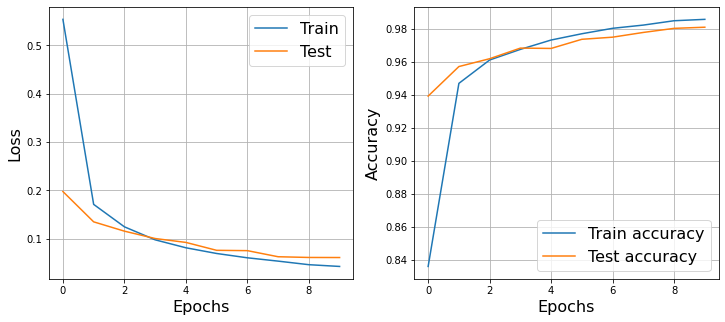

CPU times: user 14min 26s, sys: 1min 56s, total: 16min 22s
Wall time: 2min 31s


In [102]:
%%time

test_drop('none')

Epoch 9... (Train/Test) NLL: 0.447/0.052	Accuracy: 0.783/0.984


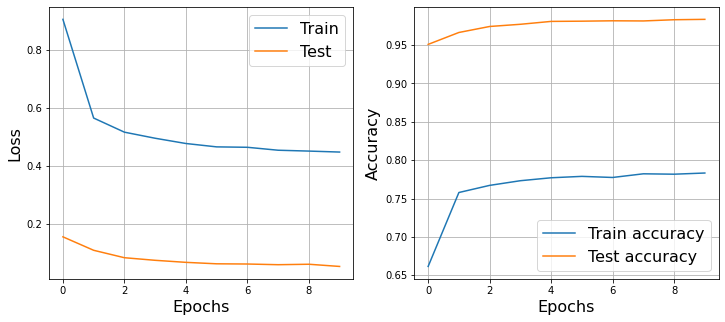

CPU times: user 14min 41s, sys: 1min 55s, total: 16min 37s
Wall time: 2min 34s


In [103]:
%%time

test_drop('dropout')

Epoch 9... (Train/Test) NLL: 0.130/0.283	Accuracy: 0.961/0.978


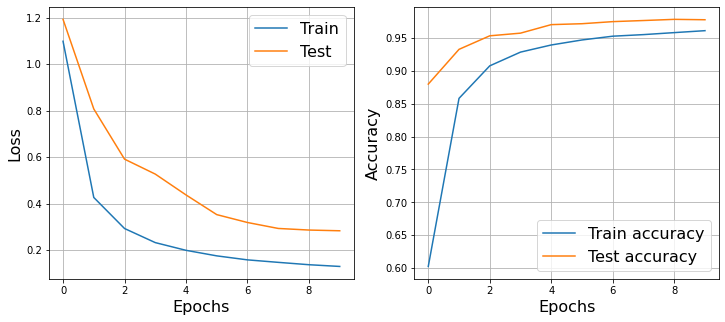

CPU times: user 16min 36s, sys: 1min 56s, total: 18min 33s
Wall time: 2min 53s


In [101]:
%%time

test_drop('dropconnect')

В test-time стохастичность Dropout убирают и заменяют все веса на их ожидаемое значение: $\mathbb{E}w = pw + (1-p)0 = pw$.

<i> 2.3 Сделайте выводы по третьей части. </i>

**Выводы**: DropOut помог увеличить качество, а DropConnect его немного ухудшил. Хотя возможно, на большем количестве эпох они бы сравнялись, т.к. из графика для DropOut видно, что у него есть потенциал для роста - Test "не догнал" Train.

### Часть 3: Batch Normalization

Наконец, давайте рассмотрим Batch Normalization. Этот слой вычитает среднее и делит на стандартное отклонение. Среднее и дисперсия вычисляются по батчу независимо для каждого нейрона. У этого слоя есть две важные проблемы: его нельзя использовать при обучении с размером батча 1 и он делает элементы батча зависимыми. Давайте реализуем аналог батч нормализации: <a href=https://arxiv.org/pdf/1607.06450.pdf>Layer normalization</a>. В layer normalization среднее и дисперсия вычисляются по активациям нейронов, независимо для каждого объекта.

<i> 3.1 Реализуйте Layer Normalization </i>

In [141]:
# полезные функции: .std(dim), .mean(dim)

class LayerNormalization(nn.Module):
    def forward(self, x):
        mean = torch.mean(x, dim=0)
        std = torch.std(x, dim=0)
        output = (x - mean) / (std + 1e-05)
        return output

<i> 
3.2 Сравните графики обучения нейроных сетей:
1. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Batch normalization между всеми слоями 
2. Свертки из TestNetwork -> 128 -> 128 -> 10 с ReLU и Layer normalization между всеми слоями 
</i>

In [195]:
def test_norm(mode='layer', learning_rate=0.001):
    sizes = [196, 128, 128, 10]
    layers = []
    for size_input, size_output in zip(sizes, sizes[1:]):
        layers.append(nn.Linear(size_input, size_output))
        layers.append(nn.ReLU())
        if mode == 'layer':
            layers.append(LayerNormalization())
        elif mode == 'batch':
            layers.append(nn.BatchNorm1d(size_output))        

    del layers[-2:]

    from train_utils import train

    network = TestNetwork(nn.Sequential(*layers))

    train(network, train_loader, test_loader, 10, 0.001, device='cpu')

Epoch 9... (Train/Test) NLL: 0.028/0.061	Accuracy: 0.991/0.982


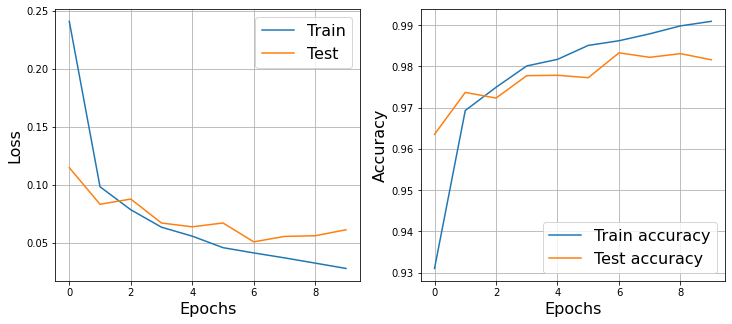

In [143]:
test_norm('layer')

Epoch 9... (Train/Test) NLL: 0.029/0.061	Accuracy: 0.990/0.981


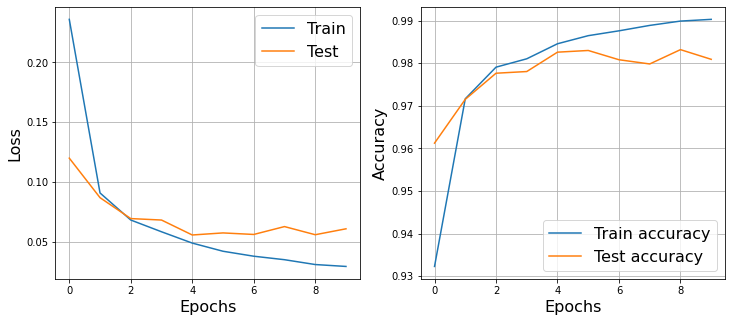

In [146]:
test_norm('batch')

Epoch 9... (Train/Test) NLL: 0.039/0.047	Accuracy: 0.987/0.982


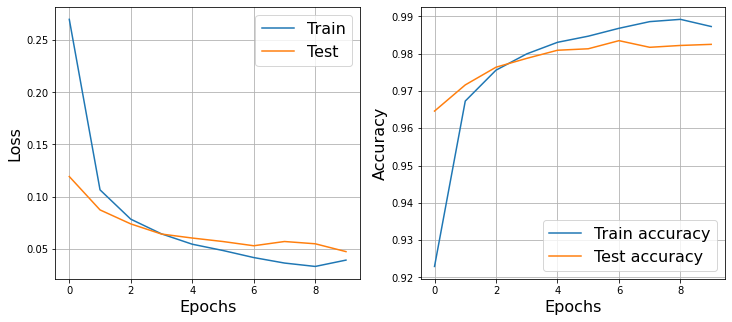

In [196]:
test_norm('layer', 0.01)

<i> 3.3 Сделайте выводы по третьей части </i>

**Выводы**: Нормализация позволяет сети учиться быстрее и лучше - 0.93/0.96 на трейне/тесте после первой эпохи, и итоговое качество лучше. Также можно это даёт возможность выбрать learning_rate побольше без потери качества на первых эпохах, что тоже позволяет выучить сеть быстрее.

#### Feedback (опционально)

Здесь вы можете оставить список опечаток из лекции или семинара:

Здесь вы можете оставить комментарии по лекции или семинару: